In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

import seaborn as sns

sns.set_style("whitegrid")

import pickle

import matplotlib.gridspec as gridspec

# Define plotting helper functions

In [2]:
def cut_out(img, box):
    x_bottom = np.min(box[:, 1])
    x_top = np.max(box[:, 1])

    y_bottom = np.min(box[:, 0])
    y_top = np.max(box[:, 0])

    img = img[y_bottom:y_top, x_bottom:x_top]
    return img


def convert_voltage_coord_to_px_coordinates(coord, d_file):
    bottom_x = d_file["chan0"]["vals"][1][0]
    res_x = np.abs(bottom_x - d_file["chan0"]["vals"][1][1])
    px_x = (coord[0] - bottom_x) / res_x
    bottom_y = d_file["chan0"]["vals"][0][0]
    res_y = np.abs(bottom_y - d_file["chan0"]["vals"][0][1])
    px_y = (coord[1] - bottom_y) / res_y

    return np.array([px_x, px_y], dtype=int)


def convert_vboxes_to_pxboxes(boxes, d_file):
    px_boxes = []
    for box in boxes:
        px_boxes.append([])
        for coord in box:
            coord_px = convert_voltage_coord_to_px_coordinates(coord, d_file)
            px_boxes[-1].append(coord_px)
    return np.array(px_boxes)

In [3]:
def get_multiple_examples(f, gs, n_examples, m_idx, plot_ylabels, cmap="icefire"):
    gs00 = gs.subgridspec(1, n_examples)

    i_new = {2: 0, 1: 1, 0: 2}

    for n in [2, 1, 0]:
        get_single_example(
            f, gs00[i_new[n]], n, m_idx[n], plot_ylabels[n], cmap="icefire"
        )

In [4]:
def get_confirmation_scans(
    f,
    gs,
    n_confirmations=2,
    highlights=None,
    highlightcolors=None,
    plot_ylabel=None,
    show_c_bar=False,
    cmap="plasma",
    majority_vote=False,
    n_total_votes=11,
):
    window = np.arange(25, 56)

    heights_marker = [1.2, 1.8, 4]

    gs00 = gs.subgridspec(1, n_confirmations)

    for i in [2, 1, 0]:
        i_new = {2: 0, 1: 1, 0: 2}
        gs000 = gs00[i_new[i]].subgridspec(4, 10)

        if show_c_bar:
            c_bar_devider = -1
        else:
            c_bar_devider = 10
        divider = 2
        labelspace = 0
        ax = f.add_subplot(gs000[divider:, labelspace:c_bar_devider])
        if show_c_bar:
            cax = f.add_subplot(gs000[divider + 1 :, c_bar_devider:])
            caxlabel = f.add_subplot(gs000[divider : divider + 1, c_bar_devider:])
        im = ax.imshow(
            scans[i][window].T * 10**9,
            origin="lower",
            extent=[
                np.min(magnet_range[window]),
                np.max(magnet_range[window]),
                np.min(detuning_axes[i]),
                np.max(detuning_axes[i]),
            ],
            cmap=cmap,
            aspect="auto",
        )
        ax.tick_params(which="major", direction="out", bottom=True, left=True)
        if plot_ylabel is not None:
            if plot_ylabel[i]:
                ax.set(ylabel="$\epsilon$ [mV]")
        ax.grid(False)
        ax.set(xlabel="$B$ [T]")
        for i_pred in range(len(magnet[0])):
            ax.plot(
                [magnet[0][i_pred], magnet[0][i_pred]],
                [np.min(detuning_axes[i]), np.max(detuning_axes[i])],
                linestyle=":",
                color="white",
                lw=0.5,
            )

        if highlights is not None:
            ax.plot(
                [magnet[0][highlights[i]], magnet[0][highlights[i]]],
                [np.min(detuning_axes[i]), np.max(detuning_axes[i])],
                linestyle="-",
                color=highlightcolors[i],
                lw=1,
            )

        if show_c_bar:
            f.colorbar(im, cax=cax)  # ,label='$I$ [nA]')#, orientation='horizontal')
            cax.set_yticklabels(
                np.round(cax.get_yticks(), 2), rotation="vertical", va="center"
            )

            caxlabel.text(
                0.0,
                0.0,
                "$I$ [nA]",
                rotation="vertical",
                ha="left",
                va="bottom",
                size=12,
            )
            caxlabel.axis("off")
        ax = f.add_subplot(gs000[:divider, labelspace:c_bar_devider])
        if majority_vote:
            ylim = (-0.5, n_total_votes + 0.5)
            predictions = pred_arr[0, :, i] * n_total_votes

        else:
            ylim = (-0.05, 1.05)
            predictions = pred_arr[0, :, i]

        ax.scatter(
            magnet[0],
            predictions,
            label=str(i + 1),
            marker="x",
            color="black",
            clip_on=False,
            zorder=10,
        )
        ax.set(
            ylim=ylim, xlim=(np.min(magnet_range[window]), np.max(magnet_range[window]))
        )
        if majority_vote:
            ax.set_yticks([0, 5, 11])
        else:
            ax.set_yticks([0, 0.5, 1])

        # ax.tick_params(which='major', direction="out", bottom=True, left=True)
        # ax.set_yticklabels(['','No PSB', 'PSB'])
        if plot_ylabel is not None:
            if plot_ylabel[i]:
                ax.set(ylabel="average pred.")
        if i == 1 or i == 2:
            ax.set(ylabel="")

        if majority_vote:
            ax.annotate(
                "PSB", (np.min(magnet_range[window]) + 0.01, 9.5), color="green"
            )  # , rotation='vertical',va="center")
            ax.annotate(
                "No PSB", (np.min(magnet_range[window]) + 0.01, 3.5), color="red"
            )  # , rotation='vertical',va="center")

            ax.fill_between(
                [np.min(magnet_range[window]), np.max(magnet_range[window])],
                [5, 5],
                [ylim[1], ylim[1]],
                color="green",
                alpha=0.2,
            )
            ax.fill_between(
                [np.min(magnet_range[window]), np.max(magnet_range[window])],
                [ylim[0], ylim[0]],
                [5, 5],
                color="red",
                alpha=0.2,
            )
        else:
            ax.annotate(
                "PSB", (np.min(magnet_range[window]) + 0.01, 0.85), color="green"
            )  # , rotation='vertical',va="center")
            ax.annotate(
                "No PSB", (np.min(magnet_range[window]) + 0.01, 0.35), color="red"
            )
            ax.fill_between(
                [np.min(magnet_range[window]), np.max(magnet_range[window])],
                [0.5, 0.5],
                [ylim[1], ylim[1]],
                color="green",
                alpha=0.2,
            )
            ax.fill_between(
                [np.min(magnet_range[window]), np.max(magnet_range[window])],
                [ylim[0], ylim[0]],
                [0.5, 0.5],
                color="red",
                alpha=0.2,
            )

        ax.set_xticklabels([])
        for i_pred, prediction in enumerate(predictions):
            ax.plot(
                [magnet[0][i_pred], magnet[0][i_pred]],
                [ylim[0], prediction],
                linestyle=":",
                color="white",
                lw=0.5,
            )

        if highlights is not None:
            ax.scatter(
                magnet[0][highlights[i]],
                predictions[highlights[i]],
                marker="x",
                color=highlightcolors[i],
                clip_on=False,
                zorder=10,
            )
            ax.plot(
                [magnet[0][highlights[i]], magnet[0][highlights[i]]],
                [ylim[0], predictions[highlights[i]]],
                linestyle="-",
                color=highlightcolors[i],
                lw=1,
            )


def get_voltage_space_plot(f, gs, cmap="plasma", show_c_bar=False):
    gs00 = gs.subgridspec(2, 30)
    if show_c_bar:
        c_bar_devider = -2
    else:
        c_bar_devider = 30

    ax = f.add_subplot(gs00[:, :c_bar_devider])
    if show_c_bar:
        cax = f.add_subplot(gs00[1:, c_bar_devider:])
        caxlabel = f.add_subplot(gs00[:1, c_bar_devider:])
    extent = [np.min(vals[0]), np.max(vals[0]), np.min(vals[1]), np.max(vals[1])]
    im = ax.imshow(
        data["chan0"]["data"] * 10**9,
        origin="lower",
        extent=extent,
        cmap=cmap,
        aspect="auto",
    )
    ax.grid(False)
    ax.set_xticks(np.round(extent[:2]))
    ax.set_yticks(np.round(extent[2:]))

    if show_c_bar:
        f.colorbar(im, cax=cax)
        caxlabel.text(
            0.0, 0.0, "$I$ [nA]", rotation="vertical", ha="left", va="bottom", size=12
        )
        caxlabel.axis("off")

    ax.tick_params(which="major", direction="out", bottom=True, left=True)

    for i, box in enumerate(boxes):
        ax.plot(
            [box[0, 1], box[0, 1], box[1, 1], box[1, 1], box[0, 1]],
            [box[0, 0], box[1, 0], box[1, 0], box[0, 0], box[0, 0]],
            c="white",
            linewidth=3,
            alpha=0.5,
        )

        if i == 1:
            ax.annotate(
                triangle_names[i],
                (box[0, 1] + 15, box[1, 0] + 10),
                ha="left",
                va="bottom",
                color="black",
                fontsize=14,
            )
        else:
            ax.annotate(
                triangle_names[i],
                (box[1, 1] - 15, box[1, 0] + 10),
                ha="right",
                va="bottom",
                color="black",
                fontsize=14,
            )

    ax.annotate(
        "$B=0.5$T", (-900, -1150), color="black", va="top", ha="right", fontsize=14
    )
    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -30
    ax.set(xlabel="$V\mathregular{_{P1}}$ [mV]", ylabel="$V\mathregular{_{P2}}$ [mV]")


def get_half_voltage_space_plot(f, gs, cmap="plasma", show_c_bar=False):
    img = data["chan0"]["data"] * 10**9
    ylength = img.shape[0]

    img = img[ylength // 2 :, :]

    gs00 = gs.subgridspec(2, 30)
    if show_c_bar:
        c_bar_devider = -2
    else:
        c_bar_devider = 30

    ax = f.add_subplot(gs00[:, :c_bar_devider])
    if show_c_bar:
        cax = f.add_subplot(gs00[:, c_bar_devider:])
    extent = [
        np.min(vals[0]),
        np.max(vals[0]),
        vals[1][ylength // 2],
        np.max(vals[1]),
    ]
    im = ax.imshow(img, origin="lower", extent=extent, cmap=cmap, aspect="auto")
    ax.grid(False)
    ax.set_xticks(np.round(extent[:2]))
    ax.set_yticks(np.round(extent[2:]))

    if show_c_bar:
        cbar = f.colorbar(im, cax=cax, ticks=[0.2, 0.6])

    ax.tick_params(which="major", direction="out", bottom=True, left=True)

    for i, box in enumerate(boxes[:3]):
        ax.plot(
            [box[0, 1], box[0, 1], box[1, 1], box[1, 1], box[0, 1]],
            [box[0, 0], box[1, 0], box[1, 0], box[0, 0], box[0, 0]],
            c="grey",
            linewidth=3,
            alpha=0.5,
        )

        if i == 1:
            ax.annotate(
                triangle_names[i],
                (box[0, 1] + 15, box[1, 0] + 10),
                ha="left",
                va="bottom",
                color="black",
                fontsize=14,
            )
        else:
            ax.annotate(
                triangle_names[i],
                (box[1, 1] - 15, box[1, 0] + 10),
                ha="right",
                va="bottom",
                color="black",
                fontsize=14,
            )
    ax.annotate(
        "$B=0.5$T", (-900, -1150), color="black", va="top", ha="right", fontsize=14
    )
    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -30
    ax.set(xlabel="$V\mathregular{_{P1}}$ [mV]", ylabel="$V\mathregular{_{P2}}$ [mV]")

In [5]:
def get_single_example(
    f,
    gs,
    index_transition=0,
    magnet_index=2,
    plot_ylabel=True,
    show_c_bar=False,
    show_axis=False,
    cmap="plasma",
    labelcolor="black",
):
    gs00 = gs.subgridspec(4, 10)

    if show_c_bar:
        c_div = 9
    else:
        c_div = 10
    ax = f.add_subplot(gs00[:2, :c_div])
    if show_c_bar:
        cax = f.add_subplot(gs00[1, c_div:])
        caxlabel = f.add_subplot(gs00[0, c_div:])
    data = data_array[magnet_index]
    image = cut_out(data["chan0"]["data"], px_boxes[index_transition])
    image_ref = cut_out(data_reference["chan0"]["data"], px_boxes[index_transition])

    clims = (
        np.array(
            [
                np.min((np.min(image), np.min(image_ref))),
                np.max((np.max(image), np.max(image_ref))),
            ]
        )
        * 10**9
    )

    x_bottom = data["chan0"]["vals"][0][np.min(px_boxes[index_transition, :, 1])]
    x_top = data["chan0"]["vals"][0][np.max(px_boxes[index_transition, :, 1])]
    y_bottom = data["chan0"]["vals"][1][np.min(px_boxes[index_transition, :, 0])]
    y_top = data["chan0"]["vals"][1][np.max(px_boxes[index_transition, :, 0])]

    im = ax.imshow(
        image * 10**9,
        extent=[x_bottom, x_top, y_bottom, y_top],
        origin="lower",
        cmap=cmap,
        aspect="auto",
        clim=clims,
    )
    if show_c_bar:
        f.colorbar(im, cax=cax)  # ,label='$I$ [nA]')
        cax.set_yticklabels(
            np.round(cax.get_yticks(), 1), rotation="vertical", va="center"
        )
        caxlabel.text(
            0.0, 0.0, "$I$ [nA]", rotation="vertical", ha="left", va="bottom", size=12
        )
        caxlabel.axis("off")
    ax.tick_params(which="major", direction="out", bottom=True, left=True)
    if plot_ylabel:
        ax.set(ylabel="$V\mathregular{_{G3}}$ [mV]")
    ax.grid(False)
    if not show_axis:
        ax.axis("off")
    ax.set_yticklabels(
        ax.get_yticks(), rotation="vertical", va="center"
    )  # , rotation=60)
    ax.annotate(
        "$B=" + str(np.round(magnet[0][magnet_index], 2)) + "$T",
        (x_top - 10, y_bottom + 10),
        va="bottom",
        ha="right",
        color=labelcolor,
        fontsize=14,
    )
    ax.set_xticklabels([])

    ax = f.add_subplot(gs00[2:, :c_div])
    if show_c_bar:
        cax = f.add_subplot(gs00[3, c_div:])
        caxlabel = f.add_subplot(gs00[2, c_div:])
        caxlabel.text(
            0.0, 0.0, "$I$ [nA]", rotation="vertical", ha="left", va="bottom", size=12
        )
        caxlabel.axis("off")

    image = cut_out(data_reference["chan0"]["data"], px_boxes[index_transition])

    im = ax.imshow(
        image * 10**9,
        extent=[x_bottom, x_top, y_bottom, y_top],
        origin="lower",
        cmap=cmap,
        aspect="auto",
        clim=clims,
    )
    if show_c_bar:
        f.colorbar(im, cax=cax)  # ,label='$I$ [nA]')
        caxlabel.text(
            0.0, 0.0, "$I$ [nA]", rotation="vertical", ha="left", va="bottom", size=12
        )
        caxlabel.axis("off")

        cax.set_yticklabels(
            np.round(cax.get_yticks(), 2), rotation="vertical", va="center"
        )
    ax.tick_params(which="major", direction="out", bottom=True, left=True)
    ax.set(xlabel="$V\mathregular{_{G2}}$ [mV]")
    if plot_ylabel:
        ax.set(ylabel="$V\mathregular{_{G3}}$ [mV]")
    ax.set_yticklabels(
        ax.get_yticks(), rotation="vertical", va="center"
    )  # , rotation=60)
    ax.annotate(
        "$B=0.5$T",
        (x_top - 10, y_bottom + 10),
        color=labelcolor,
        va="bottom",
        ha="right",
        fontsize=14,
    )
    ax.grid(False)
    if not show_axis:
        ax.axis("off")

    y1 = conf_scans[index_transition]["end_detuning_point"][0]
    x1 = conf_scans[index_transition]["end_detuning_point"][1]

    y2 = conf_scans[index_transition]["start_detuning_point"][0]
    x2 = conf_scans[index_transition]["start_detuning_point"][1]
    ax.plot([x1, x2], [y1, y2], ":", c="white")

# Import data

In [6]:
triangle_names = ["C", "B", "A", "F", "E", "D"]

In [7]:
(magnet, pred_arr) = pickle.load(
    open("../Data/training_results/resnet_results/preds_demo.pkl", "rb")
)

In [8]:
data_folder = "../Data/raw_data/for_psb_search_demo/experiment_2/data/positive bias/"

data_array = []
data_array.append(
    pickle.load(
        open(data_folder + "/positive bias_magnet_-0.01999999999999999.pkl", "rb")
    )
)
data_array.append(
    pickle.load(
        open(data_folder + "/positive bias_magnet_-0.039999999999999994.pkl", "rb")
    )
)
data_array.append(
    pickle.load(open(data_folder + "/positive bias_magnet_-0.06.pkl", "rb"))
)
data_array.append(
    pickle.load(open(data_folder + "/positive bias_magnet_-0.08.pkl", "rb"))
)
data_array.append(
    pickle.load(
        open(data_folder + "/positive bias_magnet_0.020000000000000018.pkl", "rb")
    )
)

In [9]:
data_folder = (
    "../Data/raw_data/for_psb_search_demo/experiment_2/data/confirmation_scans/"
)
first = pickle.load(open(data_folder + "confirmation_scan_second_run_box_0.pkl", "rb"))
second = pickle.load(open(data_folder + "confirmation_scan_second_run_box_1.pkl", "rb"))
third = pickle.load(open(data_folder + "confirmation_scan_second_run_box_2.pkl", "rb"))

scans = []
detuning_axes = []
for data in [first, second, third]:
    start_detuning_point = data["start_detuning_point"]
    end_detuning_point = data["end_detuning_point"]

    detuning_axis = np.arange(
        0, np.sqrt(np.sum((end_detuning_point - start_detuning_point) ** 2)) // 1
    )
    magnet_range = data["magnet_range"]
    # print(magnet_range)
    scan = np.array(data["scan"])
    scans.append(scan)
    detuning_axes.append(detuning_axis)

In [10]:
delta = third["end_detuning_point"] - third["start_detuning_point"]
delta_length = np.sqrt(np.sum((end_detuning_point - start_detuning_point) ** 2))
new_starting_point = third["start_detuning_point"] + 40 * delta / delta_length

third["scan"] = np.array(third["scan"])[:, 40:]
third["start_detuning_point"] = new_starting_point

detuning_axes[2] = np.arange(
    0, np.sqrt(np.sum((third["end_detuning_point"] - new_starting_point) ** 2)) // 1
)
scans[2] = np.array(third["scan"])

In [11]:
conf_scans = [first, second, third]

detuning_axes[0] -= 12
detuning_axes[1] -= 26
detuning_axes[2] -= 17

In [12]:
data_folder = (
    "../Data/raw_data/for_psb_search_demo/experiment_2/data/label_and_ref_scans/"
)
data = pickle.load(
    open(data_folder + "reference_scan_positive bias_magnet_0.5.pkl", "rb")
)
data_reference = pickle.load(
    open(data_folder + "reference_scan_positive bias_magnet_0.5.pkl", "rb")
)

data_folder = "../Data/raw_data/for_psb_search_demo/experiment_2/data/boxes/"
boxes = np.load(data_folder + "boxes_positive_bias_voltage_space.npy")
px_boxes = np.load(data_folder + "boxes_positive_bias.npy")

vals = data["chan0"]["vals"]
px_boxes = convert_vboxes_to_pxboxes(boxes, data)

/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_54075/104635358.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_54075/104635358.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(


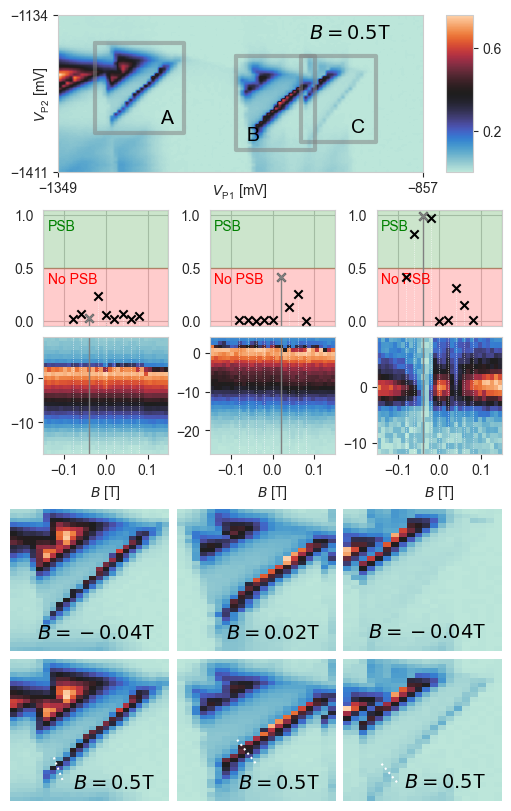

In [13]:
f = plt.figure(figsize=(5, 8), constrained_layout=True)

grid_x, grid_y = 1, 80

gs0 = gridspec.GridSpec(grid_y, grid_x, figure=f)

divider_y = 20
divider_x = 8

get_half_voltage_space_plot(f, gs0[:divider_y, :], show_c_bar=True, cmap="icefire")

get_confirmation_scans(
    f,
    gs0[divider_y:50, :],
    3,
    [1, 4, 1],
    ["grey", "grey", "grey"],
    [False, False, False],
    cmap="icefire",
)

get_multiple_examples(
    f, gs0[50:, :], 3, [1, 4, 1], [False, False, False], cmap="icefire"
)


# plt.savefig('figures/poc.pdf')
# plt.savefig('figures/poc.svg')

# Plot simulator examples

  0%|          | 0/20 [00:00<?, ?it/s]

1 5 1 5
1 5 6 10
1 5 11 15
1 5 16 20


/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_54075/3265491042.py:131: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("examples_simulator.svg")
/Users/jonasschuff/opt/anaconda3/envs/test2/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


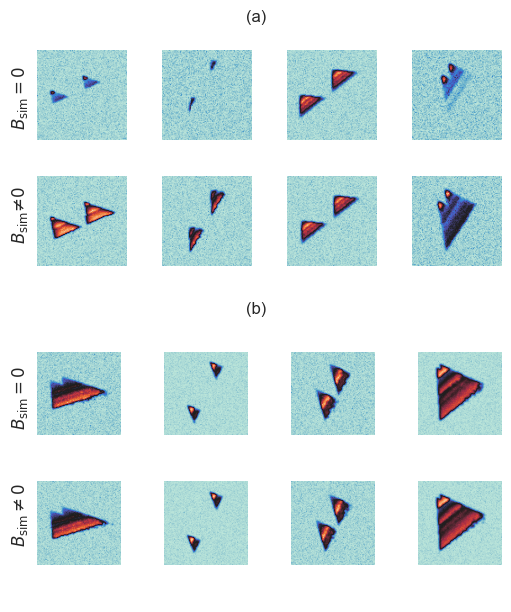

In [14]:
import sys

sys.path.append("../Simulator/")
from simulation import sample_factors, get_bias_triangles, simulate, get_simulation

imgs, psb_label, sampling_factors = simulate(20, return_sampling_factors=True)
imgs = np.array(imgs)
positives = np.array(imgs[psb_label])
negatives = np.array(imgs[np.logical_not(psb_label)])


f = plt.figure(figsize=(5, 6), constrained_layout=True)
cmap = "icefire"

gs0 = gridspec.GridSpec(2, 1, figure=f)


grid_x, grid_y = 20, 10

divider_y = 1
divider_x = 1

between_samples = 1

n_examples = 4

box_size = 4

gs00 = gs0[0].subgridspec(grid_y, grid_x)

label_ax = f.add_subplot(gs00[:divider_y, :])
label_ax.text(0.50, 0.0, "(a)", ha="center", size=12)
label_ax.axis("off")


label_ax = f.add_subplot(gs00[:, :divider_x])
label_ax.text(
    0.00, 0.7, "$B_\mathrm{sim}=0$", va="center", rotation="vertical", size=12
)
label_ax.text(
    0.00, 0.3, "$B_\mathrm{sim} \\ne 0$", va="center", rotation="vertical", size=12
)
label_ax.axis("off")

for i_ex in range(n_examples):
    ax = f.add_subplot(
        gs00[
            divider_y : divider_y + box_size,
            i_ex * between_samples
            + divider_x
            + i_ex * box_size : i_ex * between_samples
            + divider_x
            + (i_ex + 1) * box_size,
        ]
    )
    ax.imshow(
        positives[i_ex, 0], origin="lower", cmap=cmap, aspect="equal", clim=(0, 1)
    )
    ax.axis("off")
    # ax.set(clim=(0,1))
    ax = f.add_subplot(
        gs00[
            divider_y + box_size : divider_y + 2 * box_size,
            i_ex * between_samples
            + divider_x
            + i_ex * box_size : i_ex * between_samples
            + divider_x
            + (i_ex + 1) * box_size,
        ]
    )
    ax.imshow(
        positives[i_ex, 1], origin="lower", cmap=cmap, aspect="equal", clim=(0, 1)
    )
    ax.axis("off")


gs01 = gs0[1].subgridspec(grid_y, grid_x)

label_ax = f.add_subplot(gs01[:divider_y, :])
label_ax.text(0.50, 0.0, "(b)", ha="center", size=12)
label_ax.axis("off")


label_ax = f.add_subplot(gs01[:, :divider_x])
label_ax.text(
    0.00, 0.7, "$B_\mathrm{sim}=0$", va="center", rotation="vertical", size=12
)
label_ax.text(
    0.00, 0.3, "$B_\mathrm{sim} \\neq 0$", va="center", rotation="vertical", size=12
)
label_ax.axis("off")


for i_ex in range(n_examples):
    print(
        divider_y,
        divider_y + box_size,
        i_ex * between_samples + divider_x + i_ex * box_size,
        i_ex * between_samples + divider_x + (i_ex + 1) * box_size,
    )
    ax = f.add_subplot(
        gs01[
            divider_y : divider_y + box_size,
            i_ex * between_samples
            + divider_x
            + i_ex * box_size : i_ex * between_samples
            + divider_x
            + (i_ex + 1) * box_size,
        ]
    )
    ax.imshow(
        negatives[i_ex, 0], origin="lower", cmap=cmap, aspect="equal", clim=(0, 1)
    )
    ax.axis("off")
    ax.grid(False)
    ax = f.add_subplot(
        gs01[
            divider_y + box_size : divider_y + 2 * box_size,
            i_ex * between_samples
            + divider_x
            + i_ex * box_size : i_ex * between_samples
            + divider_x
            + (i_ex + 1) * box_size,
        ]
    )
    ax.imshow(
        negatives[i_ex, 1], origin="lower", cmap=cmap, aspect="equal", clim=(0, 1)
    )
    ax.axis("off")
    ax.grid(False)
plt.savefig("examples_simulator.svg")

# Plot real example

set2 pos_bias_blocked 201910_Basel_FinFET


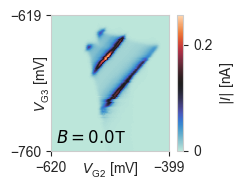

set2 neg_bias_blocked 201910_Basel_FinFET


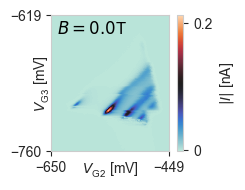

set2 neg_bias_unblocked 201910_Basel_FinFET


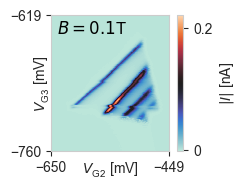

In [15]:
from igor import binarywave
import toml

config = toml.load(
    "../Data/raw_data/for_benchmarking/data/201910_Basel_FinFET/config.toml"
)
cmap = "icefire"

setname = "set2"
for condition in ["pos_bias_blocked", "neg_bias_blocked", "neg_bias_unblocked"]:
    print(setname, condition, config["title"])
    raw = binarywave.load(
        "../Data/raw_data/for_benchmarking/data/"
        + config["title"]
        + "/"
        + setname
        + "/"
        + config["structure"][setname][condition]
        + ".ibw"
    )

    x_bottom = raw["wave"]["wave_header"]["sfB"][1]
    x_top = (
        x_bottom
        + raw["wave"]["wave_header"]["sfA"][1] * raw["wave"]["wave_header"]["nDim"][1]
    )
    y_bottom = raw["wave"]["wave_header"]["sfB"][0]
    y_top = (
        y_bottom
        + raw["wave"]["wave_header"]["sfA"][0] * raw["wave"]["wave_header"]["nDim"][0]
    )

    f, ax = plt.subplots(1, 1, figsize=(2.5, 2))
    extent = [x_bottom, x_top, y_bottom, y_top]
    im = plt.imshow(
        np.abs(raw["wave"]["wData"] * 10**9),
        extent=extent,
        origin="lower",
        cmap=cmap,
        aspect="auto",
    )
    # ax.axis('off')

    cbar = f.colorbar(im, label="$|I|$ [nA]", ticks=[0.001, 0.2])
    cbar.ax.set_yticklabels(["0", "0.2"])

    # plt.colorbar(label='$|I|$ [nA]')
    ax.tick_params(which="major", direction="out", bottom=True, left=True)
    if condition in ["pos_bias_blocked", "neg_bias_blocked"]:
        B = 0.0
    else:
        B = 0.1
    ax.set(ylabel="$V\mathregular{_{G3}}$ [mV]", xlabel="$V\mathregular{_{G2}}$ [mV]")
    # ax.text(image.shape[1]*8/10, image.shape[0]/10, str(i_y+1), color='white',size=12)
    if condition == "pos_bias_blocked":
        ax.annotate(
            "$B=" + str(B) + "$T",
            (x_bottom + 10, y_bottom + 5),
            color="black",
            va="bottom",
            ha="left",
            fontsize=12,
        )
    else:
        ax.annotate(
            "$B=" + str(B) + "$T",
            (x_bottom + 10, y_top - 5),
            color="black",
            va="top",
            ha="left",
            fontsize=12,
        )
    ax.grid(False)

    ax.set_xticks(np.round(extent[:2]))
    ax.set_yticks(np.round(extent[2:]))

    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -30

    plt.tight_layout()
    # plt.savefig('figures/example_'+condition+'.svg')

    plt.show()

# Plot other examples

In [16]:
def get_bottom_half_voltage_space_plot(f, gs, cmap="icefire", show_c_bar=False):
    img = data["chan0"]["data"] * 10**9
    ylength = 120

    img = img[: ylength // 2, :]

    gs00 = gs.subgridspec(2, 30)
    if show_c_bar:
        c_bar_devider = -2
    else:
        c_bar_devider = 30

    ax = f.add_subplot(gs00[:, :c_bar_devider])
    if show_c_bar:
        cax = f.add_subplot(gs00[:, c_bar_devider:])
    extent = [
        np.min(vals[0]),
        np.max(vals[0]),
        np.min(vals[1]),
        vals[1][ylength // 2],
    ]
    print(extent)

    im = ax.imshow(img, origin="lower", extent=extent, cmap=cmap, aspect="auto")
    ax.grid(False)
    ax.set_xticks(np.round(extent[:2]))
    ax.set_yticks(np.round(extent[2:]) + [0, -1])

    if show_c_bar:
        f.colorbar(im, cax=cax, ticks=[0.2, 1.0])

    ax.tick_params(which="major", direction="out", bottom=True, left=True)

    for i, box in enumerate(boxes[3:]):
        ax.plot(
            [box[0, 1], box[0, 1], box[1, 1], box[1, 1], box[0, 1]],
            [box[0, 0], box[1, 0], box[1, 0], box[0, 0], box[0, 0]],
            c="grey",
            linewidth=3,
            alpha=0.5,
        )

        if i == 1:
            ax.annotate(
                triangle_names[i + 3],
                (box[0, 1] + 15, box[1, 0] + 10),
                ha="left",
                va="bottom",
                color="black",
                fontsize=14,
            )
        else:
            ax.annotate(
                triangle_names[i + 3],
                (box[1, 1] - 15, box[1, 0] + 10),
                ha="right",
                va="bottom",
                color="black",
                fontsize=14,
            )

    ax.annotate(
        "$B=0.5$T", (-862, -1399), color="black", va="top", ha="right", fontsize=14
    )
    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -30
    ax.set(xlabel="$V\mathregular{_{P1}}$ [mV]", ylabel="$V\mathregular{_{P2}}$ [mV]")


def get_negative_bias_voltage_space_plot(f, gs, cmap="icefire"):
    gs00 = gs.subgridspec(2, 30)
    c_bar_devider = -2
    ax = f.add_subplot(gs00[:, :c_bar_devider])
    cax = f.add_subplot(gs00[:, c_bar_devider:])
    vals = neg_bias_data["chan0"]["vals"]
    extent = [np.min(vals[0]), np.max(vals[0]), np.min(vals[1]), np.max(vals[1])]
    print(extent)
    im = ax.imshow(
        np.abs(neg_bias_data["chan0"]["data"] * 10**9),
        origin="lower",
        extent=extent,
        cmap=cmap,
        aspect="auto",
    )
    ax.grid(False)

    ax.set_xticks([-1324, -845])
    ax.set_yticks([-1620, -1081])

    f.colorbar(im, cax=cax, ticks=[0.2, 0.8])

    ax.tick_params(which="major", direction="out", bottom=True, left=True)

    for i, box in enumerate(neg_bias_voltage_boxes):
        ax.plot(
            [box[0, 1], box[0, 1], box[1, 1], box[1, 1], box[0, 1]],
            [box[0, 0], box[1, 0], box[1, 0], box[0, 0], box[0, 0]],
            c="grey",
            linewidth=3,
            alpha=0.5,
        )

        if i == 1 or i == 4:
            ax.annotate(
                neg_triangle_names[i],
                (box[0, 1] + 15, box[1, 0] + 10),
                ha="left",
                va="bottom",
                color="black",
                fontsize=14,
            )
        else:
            ax.annotate(
                neg_triangle_names[i],
                (box[1, 1] - 15, box[1, 0] + 10),
                ha="right",
                va="bottom",
                color="black",
                fontsize=14,
            )
    ax.annotate(
        "$B=0.5$T", (-850, -1100), color="black", va="top", ha="right", fontsize=14
    )
    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -20

    ax.set(xlabel="$V\mathregular{_{P1}}$ [mV]", ylabel="$V\mathregular{_{P2}}$ [mV]")


neg_triangle_names = ["I", "H", "G", "L", "K", "J"]  # ['G','H','I','J','K','L']


plotting_range_x = [-0.1, 0.1]


def get_neg_pred_plot(f, gs, majority_vote=False):
    gs0 = gs.subgridspec(2, 3)

    for i in range(6)[::-1]:
        i_new = {5: 3, 4: 4, 3: 5, 2: 0, 1: 1, 0: 2}
        ax = f.add_subplot(gs0[i_new[i]])

        if majority_vote:
            ylim = (-0.5, 11.5)
            predictions = pred_arr[1, :, i] * 11
        else:
            ylim = (-0.05, 1.05)
            predictions = pred_arr[1, :, i]

        ax.scatter(
            magnet[1], predictions, marker="x", color="black", zorder=10, clip_on=False
        )
        ax.set(ylim=ylim, xlim=plotting_range_x)
        ax.set(ylabel="avg. score")

        if i in [0, 1, 3, 4]:
            ax.set(ylabel="")
        if i in [0, 1, 3, 4]:
            ax.set_yticklabels([])

        if majority_vote:
            ax.set_yticks([0, 5, 11])
            ax.annotate(
                "PSB", (plotting_range_x[0] + 0.01, 10), color="green", va="top"
            )
            ax.annotate(
                "No PSB", (plotting_range_x[0] + 0.01, 4), color="red", va="top"
            )
            ax.set(title=neg_triangle_names[i])

            ax.fill_between(
                plotting_range_x, [5, 5], [ylim[1], ylim[1]], color="green", alpha=0.2
            )
            ax.fill_between(
                plotting_range_x, [ylim[0], ylim[0]], [5, 5], color="red", alpha=0.2
            )
        else:
            ax.set_yticks([0, 0.5, 1])
            ax.annotate(
                "PSB", (plotting_range_x[0] + 0.01, 0.9), color="green", va="top"
            )
            ax.annotate(
                "No PSB", (plotting_range_x[0] + 0.01, 0.4), color="red", va="top"
            )
            ax.set(title=neg_triangle_names[i])

            ax.fill_between(
                plotting_range_x,
                [0.5, 0.5],
                [ylim[1], ylim[1]],
                color="green",
                alpha=0.2,
            )
            ax.fill_between(
                plotting_range_x, [ylim[0], ylim[0]], [0.5, 0.5], color="red", alpha=0.2
            )
        ax.set(xlabel="$B$ [T]")
        if i not in [3, 4, 5]:
            ax.set_xticklabels([])
            ax.set(xlabel="")


window = np.arange(25, 56)

plotting_range_x = [-0.1, 0.1]


def get_rest_pos_pred_plot(f, gs, majority_vote=False):
    gs0 = gs.subgridspec(1, 3)
    for i in [5, 4, 3]:
        i_new = {5: 3, 4: 4, 3: 5}

        ax = f.add_subplot(gs0[:, i_new[i] - 3])
        if majority_vote:
            ylim = (-0.5, 11.5)
            predictions = pred_arr[0, :, i] * 11
        else:
            ylim = (-0.05, 1.05)
            predictions = pred_arr[0, :, i]
        ax.scatter(
            magnet[0], predictions, marker="x", color="black", zorder=10, clip_on=False
        )

        ax.set(ylabel="avg. score")
        if i in [1, 2, 3, 4]:
            ax.set(ylabel="")
        ax.set(title=triangle_names[i])
        ax.set(xlabel="$B$ [T]")
        if i in [0, 1, 2, 3, 5]:
            ax.set(xlabel="")
        if majority_vote:
            ax.set_yticks([0, 5, 11])
            ax.annotate(
                "PSB", (plotting_range_x[0] + 0.01, 10), color="green", va="top"
            )  # , rotation='vertical',va="center")
            ax.annotate(
                "No PSB", (plotting_range_x[0] + 0.01, 4), color="red", va="top"
            )  # , rotation='vertical',va="center")

            ax.fill_between(
                plotting_range_x, [5, 5], [ylim[1], ylim[1]], color="green", alpha=0.2
            )
            ax.fill_between(
                plotting_range_x, [ylim[0], ylim[0]], [5, 5], color="red", alpha=0.2
            )
        else:
            ax.set_yticks([0, 0.5, 1])
            ax.annotate(
                "PSB", (plotting_range_x[0] + 0.01, 0.9), color="green", va="top"
            )  # , rotation='vertical',va="center")
            ax.annotate(
                "No PSB", (plotting_range_x[0] + 0.01, 0.4), color="red", va="top"
            )  # , rotation='vertical',va="center")

            ax.fill_between(
                plotting_range_x,
                [0.5, 0.5],
                [ylim[1], ylim[1]],
                color="green",
                alpha=0.2,
            )
            ax.fill_between(
                plotting_range_x, [ylim[0], ylim[0]], [0.5, 0.5], color="red", alpha=0.2
            )
        if i is not 5:
            ax.set_yticklabels([])

<>:265: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:265: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_54075/594720063.py:265: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if i is not 5:


In [17]:
neg_triangle_names = ["I", "H", "G", "L", "K", "J"]


data_folder = (
    "../Data/raw_data/for_psb_search_demo/experiment_2/data/label_and_ref_scans/"
)
neg_bias_data = pickle.load(
    open(data_folder + "reference_scan_negative bias_magnet_0.5.pkl", "rb")
)

data_folder = "../Data/raw_data/for_psb_search_demo/experiment_2/data/boxes/"
neg_bias_voltage_boxes = np.load(data_folder + "boxes_negative_bias_voltage_space.npy")
neg_bias_boxes = convert_vboxes_to_pxboxes(neg_bias_voltage_boxes, neg_bias_data)

[-1349.367088607595, -856.9620253164558, -1689.240506329114, -1386.1334867663982]
[-1324.0506329113923, -844.3037974683544, -1620.886075949367, -1080.379746835443]


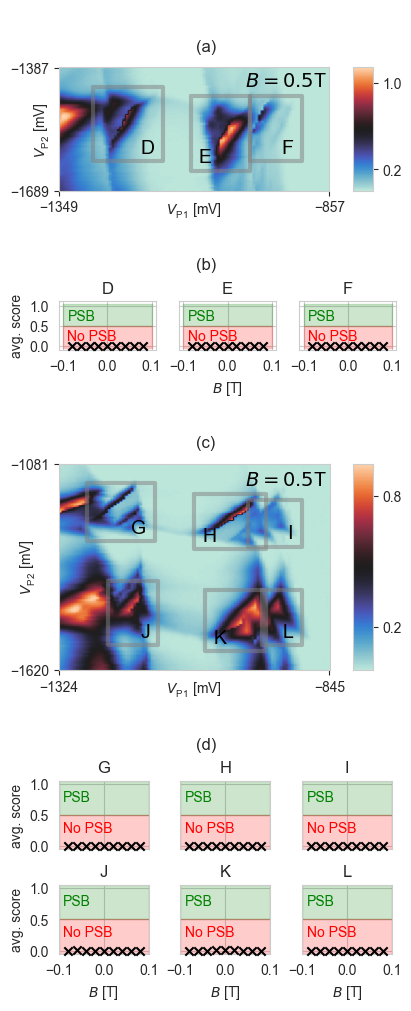

In [18]:
f = plt.figure(figsize=(4, 10), constrained_layout=True)


gs0 = gridspec.GridSpec(23, 1, figure=f)

label_ax = f.add_subplot(gs0[0, :])
label_ax.text(0.5, 0.0, "(a)", ha="center", size=12)
label_ax.axis("off")

get_bottom_half_voltage_space_plot(f, gs0[1:5], show_c_bar=True)


label_ax = f.add_subplot(gs0[5, :])
label_ax.text(0.5, 0.0, "(b)", ha="center", size=12)
label_ax.axis("off")

get_rest_pos_pred_plot(f, gs0[6:9])

label_ax = f.add_subplot(gs0[9, :])
label_ax.text(0.5, 0.0, "(c)", ha="center", size=12)
label_ax.axis("off")

get_negative_bias_voltage_space_plot(f, gs0[10:16])


label_ax = f.add_subplot(gs0[16, :])
label_ax.text(0.5, 0.0, "(d)", ha="center", size=12)
label_ax.axis("off")

get_neg_pred_plot(f, gs0[17:])


# plt.savefig('/appendix_predictions.pdf')
# plt.savefig('/appendix_predictions.svg')